## Simulation as Optimization: Finding Paths of Least Action with Gradient Descent
Tim Strang and Sam Greydanus | 2023 | MIT License

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch, time

from celluloid import Camera
from IPython.display import HTML
from base64 import b64encode

In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
from main import * # SimOpt code

In [9]:
def plot_action_stats(ax, S, T, V, S_ode, T_ode, V_ode):
    plot_config = [(S, 'k', '$S$'), (T, 'r', '$\sum_i T_i$'), (-np.asarray(V), 'b', '$-\sum_i V_i$'),
                   (S_ode, 'k--', '$S$ (ODE)'), (T_ode, 'r--', '$-\sum_i T_i$ (ODE)'),
                   (-V_ode, 'b--', '$-\sum_i V_i$ (ODE)')]
    N = len(S)
    for i, (x, fmt, label) in enumerate(plot_config):
        if i <= 2:
            ax.plot(np.arange(N), x, fmt, linewidth=4, label=label)
        else:
            ax.plot([0,N], [x]*2, fmt, linewidth=4, label=label)
            
def plot_helper(ax, ax_labels):
    plt.title(ax_labels['title'], fontweight="bold")
    plt.legend(ncol=2)
    plt.xlabel(ax_labels['x_label'])
    plt.ylabel(ax_labels['y_label'])
    for item in [ax.xaxis.label, ax.yaxis.label]:
        item.set_fontsize(23)
    ax.title.set_fontsize(19)
    ax.tick_params(axis='both', length=9, width=3, labelsize=15)
    plt.tight_layout()  # helps clean up plots sometimes
    
def action_plot(info, x_sim, ax_labels, L_fn, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(8.3333, 6.25), dpi=50)
    ax = fig.add_subplot(111)
    S_ode, T_ode, V_ode = action(torch.tensor(x_sim), L_fn=L_fn, dt=dt)
    plot_action_stats(ax, info['S'], info['T'], info['V'], S_ode, T_ode.sum(), V_ode.sum())

    plot_helper(ax, ax_labels)
    return fig

## Free body

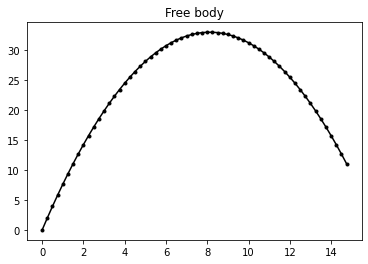

In [10]:
t_sim, x_sim = simulate_freebody(dt=0.25, steps=60)
plt.title('Free body')
plt.plot(t_sim, x_sim, 'k.-')
plt.show()

In [11]:
dt = 0.25 ; N = 1 ; steps = 60
t_sim, x_sim = simulate_freebody(dt=dt, steps=steps)
init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.5e0, zero_basepath=True) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e0, 
                                       L_fn=lagrangian_freebody, dt=dt, opt='adam')

step=0000, S=5.464e+01 J*s, dt=0.0s
step=0033, S=-1.036e+00 J*s, dt=0.0s
step=0066, S=-4.900e+00 J*s, dt=0.0s
step=0099, S=-7.694e+00 J*s, dt=0.0s
step=0132, S=-9.885e+00 J*s, dt=0.0s
step=0165, S=-1.147e+01 J*s, dt=0.0s
step=0198, S=-1.254e+01 J*s, dt=0.0s
step=0231, S=-1.320e+01 J*s, dt=0.0s
step=0264, S=-1.358e+01 J*s, dt=0.0s
step=0297, S=-1.379e+01 J*s, dt=0.0s
step=0330, S=-1.390e+01 J*s, dt=0.0s
step=0363, S=-1.395e+01 J*s, dt=0.0s
step=0396, S=-1.397e+01 J*s, dt=0.0s
step=0429, S=-1.398e+01 J*s, dt=0.0s
step=0462, S=-1.399e+01 J*s, dt=0.0s
step=0495, S=-1.399e+01 J*s, dt=0.0s


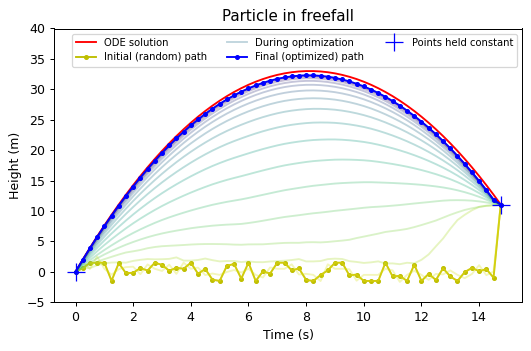

In [12]:
plt.figure(dpi=90)
plt.title('Particle in freefall')
plt.plot(t_sim, x_sim, 'r-', label='ODE solution')

plt.plot(t_min, xs_min[0], 'y.-', label='Initial (random) path')
for i, xi in enumerate(xs_min):
    label = 'During optimization' if i==10 else None
    plt.plot(t_min, xi, alpha=0.3, color=plt.cm.viridis( 1-i/(len(xs_min)-1) ), label=label)
plt.plot(t_min, xs_min[-1], 'b.-', label='Final (optimized) path')
plt.plot(t_min[[0,-1]], xs_min[0].data[[0,-1]], 'b+', markersize=15, label='Points held constant')

plt.ylim(-5, 40)
plt.xlabel('Time (s)') ; plt.ylabel('Height (m)') ; plt.legend(fontsize=8, ncol=3)
plt.tight_layout() ; plt.show()

./static/freebody_action.pdf


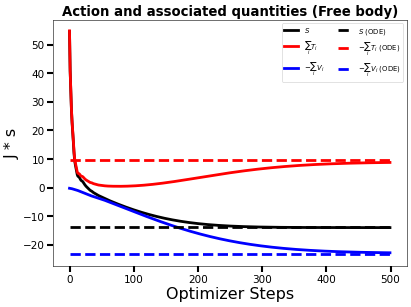

In [13]:
name = 'Free body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_freebody)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Single pendulum

In [119]:
def minimize_action(path, steps, step_size, L_fn, dt, opt='sgd', print_every=15, e_coeff=1e-6):
    t = np.linspace(0, len(path.x)-1, len(path.x)) * dt
    optimizer = torch.optim.SGD(path.parameters(), lr=step_size, momentum=0) if opt=='sgd' else \
                torch.optim.Adam(path.parameters(), lr=step_size)
    xs = [path.x.clone().data]
    S_init, T_init, V_init = action(path.x, L_fn, dt)
    E_init = (T_init[0] + V_init[0]).item()
    print('Initial energies (total/kinetic/potential):', E_init, T_init[0].item(), V_init[0].item())
    info = {'S' : [], 'T' : [], 'V' : [], 'energy_loss':[],'loss':[]}
    t0 = time.time()
    for i in range(steps):
        S, T, V = action(path.x, L_fn, dt)
        energy_loss = e_coeff*(E_init - (T+V)).abs().mean()
#         print(E_init, T[20]+V[20])
        loss = S + energy_loss
        info['S'].append(S.item()) ; info['T'].append(T.sum().item()) ; info['V'].append(V.sum().item())
        info['energy_loss'].append(energy_loss.item()) ; info['loss'].append(loss.item())
        
        loss.backward() ; path.x.grad.data[[0,-1]] *= 0
        optimizer.step() ; path.zero_grad()

        if i % (steps//print_every) == 0:
            xs.append(path.x.clone().data)
            print('step={:04d}, loss={:.3e}, S={:.3e} J*s, E_loss={:.3e}, dt={:.1f}s'\
                  .format(i, loss.item(), S.item(), energy_loss.item(), time.time()-t0))
            t0 = time.time()
    return t, path, xs, info

class PerturbedPath(torch.nn.Module):
    def __init__(self, x_true, N, sigma=0, shift=False, zero_basepath=False, coords=2, is_ephemeris=False):
        super(PerturbedPath, self).__init__()
        np.random.seed(0)
        self.x_true = x_true
        x_noise = sigma*np.random.randn(*x_true.shape).clip(-1,1)
        x_noise[:3] = x_noise[-1:] = 0
        if is_ephemeris:
            x_noise[:,0,:] = 0 # don't perturb the Sun
        x_basepath = np.copy(x_true)
        x_basepath[1:-1] = x_basepath[1:-1]*0 if zero_basepath else x_basepath[1:-1]
        self.x_pert = x_pert = (x_basepath + x_noise).reshape(-1, N*coords)
        if shift:
            x_pert_shift = np.concatenate([x_pert[5:-5,2:], x_pert[5:-5,:2]], axis=-1)
            self.x_pert[5:-5] = x_pert[5:-5] = x_pert_shift
            print(self.x_pert.shape)
        self.x = torch.nn.Parameter(torch.tensor(x_pert)) # [time, N*2]

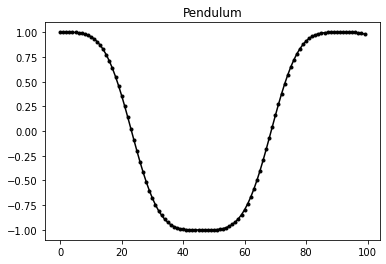

In [120]:
dt = 1
t_sim, x_sim = simulate_pend(dt=dt)
plt.title('Pendulum')
plt.plot(t_sim, np.sin(x_sim), 'k.-')
plt.show()

In [121]:
# S, T, V = action(torch.tensor(x), lagrangian_pend, dt)
# plt.plot(T, label='T')
# plt.plot(V, label='V')
# plt.plot(T+V, label='Total E')
# print(T+V)
# plt.legend() ; plt.show()

Initial energies (total/kinetic/potential): 1.4999999999999998 0.0 1.4999999999999998
step=0000, loss=1.204e+05, S=1.085e+04 J*s, E_loss=1.095e+05, dt=0.0s
step=0040, loss=7.820e+03, S=6.375e+02 J*s, E_loss=7.183e+03, dt=0.0s
step=0080, loss=1.044e+03, S=3.510e+01 J*s, E_loss=1.009e+03, dt=0.0s
step=0120, loss=5.674e+02, S=4.842e-01 J*s, E_loss=5.669e+02, dt=0.0s
step=0160, loss=3.092e+02, S=-1.145e+01 J*s, E_loss=3.206e+02, dt=0.0s
step=0200, loss=2.022e+02, S=-1.630e+01 J*s, E_loss=2.185e+02, dt=0.0s
step=0240, loss=1.104e+02, S=-1.951e+01 J*s, E_loss=1.299e+02, dt=0.0s
step=0280, loss=6.804e+01, S=-2.162e+01 J*s, E_loss=8.967e+01, dt=0.0s
step=0320, loss=3.840e+01, S=-2.291e+01 J*s, E_loss=6.131e+01, dt=0.0s
step=0360, loss=1.699e+01, S=-2.341e+01 J*s, E_loss=4.039e+01, dt=0.0s
step=0400, loss=1.350e+01, S=-2.340e+01 J*s, E_loss=3.690e+01, dt=0.0s
step=0440, loss=8.593e+00, S=-2.346e+01 J*s, E_loss=3.205e+01, dt=0.0s
step=0480, loss=8.026e+00, S=-2.351e+01 J*s, E_loss=3.153e+01, dt=

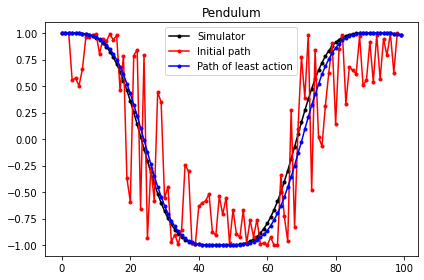

In [123]:
dt = 1 ; N = 1
t_sim, x_sim = simulate_pend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1.0e0, zero_basepath=False) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=600, step_size=2e-2, 
                                       L_fn=lagrangian_pend, dt=dt, opt='adam', e_coeff=1e3) #1e-3

plt.title('Pendulum')
plt.plot(t_sim, np.sin(x_sim), 'k.-', label='Simulator')
plt.plot(t_min, np.sin(xs_min[0]), 'r.-', label='Initial path')
plt.plot(t_min, np.sin(xs_min[-1]), 'b.-', label='Path of least action')
plt.legend()
plt.tight_layout() ; plt.show()

./static/pendulum_action.pdf


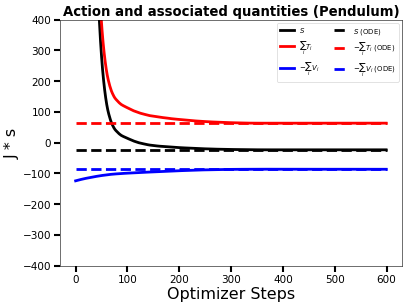

In [124]:
name = 'Pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_pend)
plt.ylim(-400, 400)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Double pendulum

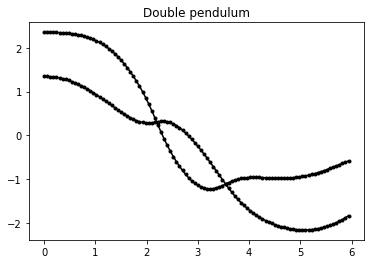

In [125]:
t_sim, x_sim = simulate_dblpend(dt=0.06)
plt.title('Double pendulum')
plt.plot(t_sim, x_sim, 'k.-')
plt.show()

# make_video(radial2cartesian(x_sim), path='sim.mp4', interval=60, ms=20)
# mp4 = open('sim.mp4','rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
# HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

tensor([0.0026, 0.0027, 0.0027, 0.0027, 0.0028, 0.0028, 0.0028, 0.0029, 0.0029,
        0.0029, 0.0030, 0.0030, 0.0030, 0.0031, 0.0031, 0.0031, 0.0032, 0.0032,
        0.0032, 0.0033, 0.0033, 0.0033, 0.0034, 0.0034, 0.0034, 0.0035, 0.0035,
        0.0036, 0.0036, 0.0037, 0.0038, 0.0039, 0.0040, 0.0041, 0.0042, 0.0041,
        0.0039, 0.0037, 0.0036, 0.0036, 0.0038, 0.0039, 0.0041, 0.0042, 0.0043,
        0.0044, 0.0045, 0.0046, 0.0046, 0.0047, 0.0048, 0.0048, 0.0049, 0.0049,
        0.0050, 0.0050, 0.0050, 0.0049, 0.0048, 0.0047, 0.0046, 0.0046, 0.0046,
        0.0046, 0.0047, 0.0047, 0.0048, 0.0048, 0.0048, 0.0049, 0.0049, 0.0050,
        0.0050, 0.0050, 0.0051, 0.0051, 0.0051, 0.0052, 0.0052, 0.0052, 0.0053,
        0.0053, 0.0053, 0.0054, 0.0054, 0.0054, 0.0054, 0.0055, 0.0055, 0.0055,
        0.0056, 0.0056, 0.0056, 0.0057, 0.0057, 0.0058, 0.0058, 0.0058, 0.0059,
        0.0049], dtype=torch.float64)


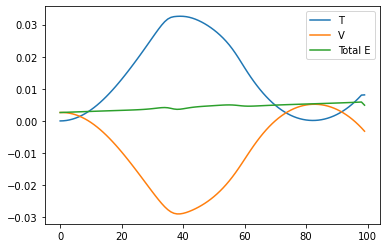

In [128]:
x = x_sim
S, T, V = action(torch.tensor(x), lagrangian_dblpend, dt)
plt.plot(T, label='T')
plt.plot(V, label='V')
plt.plot(T+V, label='Total E')
print(T+V)
plt.legend() ; plt.show()

Initial energies (total/kinetic/potential): 0.0026206491327391856 0.0 0.0026206491327391856
step=0000, loss=3.894e+02, S=3.894e+02 J*s, E_loss=0.000e+00, dt=0.0s
step=0066, loss=4.743e+01, S=4.743e+01 J*s, E_loss=0.000e+00, dt=0.1s
step=0132, loss=9.188e+00, S=9.188e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0198, loss=3.934e+00, S=3.934e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0264, loss=2.900e+00, S=2.900e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0330, loss=2.579e+00, S=2.579e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0396, loss=2.441e+00, S=2.441e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0462, loss=2.366e+00, S=2.366e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0528, loss=2.317e+00, S=2.317e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0594, loss=2.282e+00, S=2.282e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0660, loss=2.257e+00, S=2.257e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0726, loss=2.238e+00, S=2.238e+00 J*s, E_loss=0.000e+00, dt=0.0s
step=0792, loss=2.223e+00, S=2.223e+00 J*s, E_loss=0.000e+00, dt=0.0

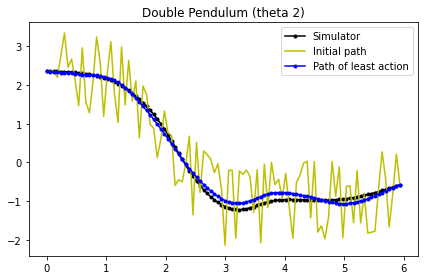

In [140]:
dt = 0.06 ; N = 2
t_sim, x_sim = simulate_dblpend(dt=dt)

init_path = PerturbedPath(x_sim, N=N, coords=1, sigma=1e0, zero_basepath=False) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=1000, step_size=1e-2, 
                                       L_fn=lagrangian_dblpend, dt=dt, opt='adam', e_coeff=0) # 1e2


plt.title('Double Pendulum (theta 2)')
plt.plot(t_sim, x_sim[:,1], 'k.-', label='Simulator')
plt.plot(t_min, xs_min[0][:,1], 'y-', label='Initial path')
plt.plot(t_min, xs_min[-1][:,1], 'b.-', label='Path of least action')
plt.legend()
plt.tight_layout() ; plt.show()

make_video(radial2cartesian(xs_min[-1]), path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/doublependulum_action.pdf


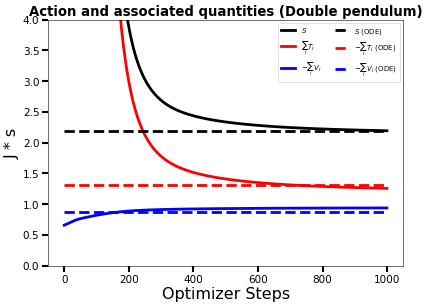

In [141]:
name = 'Double pendulum'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_dblpend)
plt.ylim(0, 4)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Three body problem

In [142]:
t, x = simulate_3body()
make_video(x, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [143]:
dt = 0.5 ; N = 3

t_sim, x_sim = simulate_3body(dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=125, step_size=1e1,
                                       L_fn=lagrangian_3body, dt=dt, opt='sgd')

IndexError: invalid index of a 0-dim tensor. Use `tensor.item()` in Python or `tensor.item<T>()` in C++ to convert a 0-dim tensor to a number

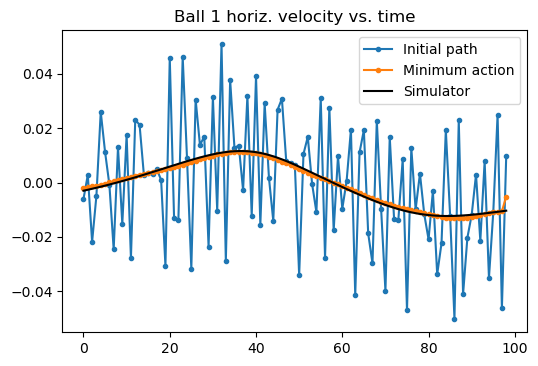

In [16]:
N = x_sim.shape[-2]
xs_before = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_after = xs_min[-1].detach().numpy().reshape(-1,N,2)

plt.figure(dpi=100) ; k = 1
plt.title('Ball {} horiz. velocity vs. time'.format(1 + k//2))
plt.plot((xs_before[1:] - xs_before[:-1]).reshape(-1,N*2)[...,k], '.-', label='Initial path')
plt.plot((xs_after[1:] - xs_after[:-1]).reshape(-1,N*2)[...,k], '.-', label='Minimum action')
plt.plot((x_sim[1:] - x_sim[:-1]).reshape(-1,N*2)[...,k], 'k-', label='Simulator')
plt.legend()
plt.show()

In [17]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=60, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [18]:
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=20)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/threebody_action.pdf


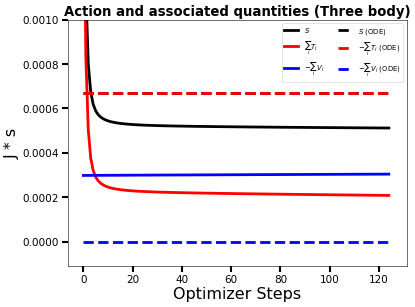

In [22]:
name = 'Three body'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_3body)
plt.ylim(None, 0.001)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Gas simulation

In [23]:
t, x = simulate_gas(dt=.5, N=50)

make_video(x, path='sim.mp4', interval=30)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

In [24]:
dt = 0.5 ; N = 50
t_sim, x_sim = simulate_gas(dt=dt, N=N)
init_path = PerturbedPath(x_sim, N=N, sigma=1e-2) # [time, N*2]
t_min, path, xs_min, info = minimize_action(init_path, steps=500, step_size=1e1,
                                       L_fn=lagrangian_gas, dt=dt, opt='sgd')

step=0000, S=-1.674e-04 J*s, dt=0.1s
step=0033, S=-4.765e-04 J*s, dt=1.6s
step=0066, S=-5.389e-04 J*s, dt=1.6s
step=0099, S=-5.562e-04 J*s, dt=1.6s
step=0132, S=-5.630e-04 J*s, dt=1.7s
step=0165, S=-5.665e-04 J*s, dt=1.6s
step=0198, S=-5.686e-04 J*s, dt=1.6s
step=0231, S=-5.701e-04 J*s, dt=1.6s
step=0264, S=-5.713e-04 J*s, dt=1.6s
step=0297, S=-5.722e-04 J*s, dt=1.6s
step=0330, S=-5.729e-04 J*s, dt=1.6s
step=0363, S=-5.736e-04 J*s, dt=1.7s
step=0396, S=-5.741e-04 J*s, dt=1.6s
step=0429, S=-5.747e-04 J*s, dt=1.6s
step=0462, S=-5.751e-04 J*s, dt=1.6s
step=0495, S=-5.756e-04 J*s, dt=1.6s


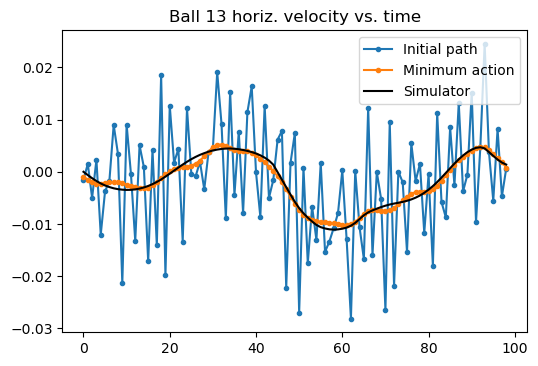

In [25]:
N = x_sim.shape[-2]
xs_before = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_after = xs_min[-1].detach().numpy().reshape(-1,N,2)

k = 25
plt.figure(dpi=100)
plt.title('Ball {} horiz. velocity vs. time'.format(1 + k//2))
plt.plot((xs_before[1:] - xs_before[:-1]).reshape(-1,N*2)[...,k], '.-', label='Initial path')
plt.plot((xs_after[1:] - xs_after[:-1]).reshape(-1,N*2)[...,k], '.-', label='Minimum action')
plt.plot((x_sim[1:] - x_sim[:-1]).reshape(-1,N*2)[...,k], 'k-', label='Simulator')
plt.legend()
plt.show()

In [26]:
xs = xs_min[0].detach().numpy().reshape(-1,N,2)
make_video(xs, path='sim.mp4', interval=30, ms=10)
mp4 = open('sim.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML('<video width=300 controls><source src="{}" type="video/mp4"></video>'.format(data_url))

./static/gas_action.pdf


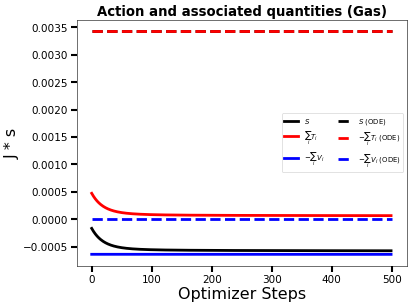

In [27]:
name = 'Gas'
ax_labels = {'title':'Action and associated quantities ({})'.format(name),
                 'x_label':'Optimizer Steps', 'y_label':'J * s'}
fig = action_plot(info, x_sim, ax_labels, L_fn=lagrangian_3body)
# plt.ylim(None, 0.001)
path ='./static/{}_action.pdf'.format(name.lower().replace(' ', '')) ; print(path)
plt.show() #; fig.savefig(path)

## Ephemeris dataset and simulation

Loading ./data/ephemeris_ablate.csv...


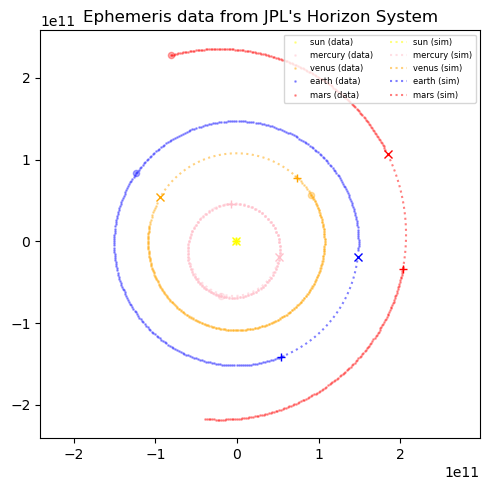

In [9]:
planets = ['sun', 'mercury', 'venus', 'earth', 'mars']
data_dir = './data/'
df = process_raw_ephemeris(planets, data_dir, last_n_days=365) #365

t_sim, x_sim = simulate_planets(df, planets)
plot_planets(df, planets)

colors = get_planet_colors()
for i, (planet, coords) in enumerate(zip(planets, x_sim.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (sim)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=2) ; plt.show()

In [19]:
dt = 24*60*60 ; N = len(planets)
df = process_raw_ephemeris(planets, data_dir, last_n_days=365)
t_sim, x_sim = simulate_planets(df, planets, dt=dt)
init_path = PerturbedPath(x_sim, N=N, sigma=2e10, is_ephemeris=True) # [time, N*2]

L_planets = partial(lagrangian_planets, masses=get_masses(planets))

t_min, path, xs_min = minimize_action(init_path, steps=500, step_size=1e9,
                                       L_fn=L_planets, dt=dt, opt='adam')

Loading ./data/ephemeris_ablate.csv...
step=0000, S=1.259e+35 J*s, dt=0.0s
step=0033, S=1.955e+36 J*s, dt=0.5s
step=0066, S=4.602e+34 J*s, dt=0.5s
step=0099, S=6.424e+33 J*s, dt=0.5s
step=0132, S=4.069e+33 J*s, dt=0.5s
step=0165, S=3.906e+33 J*s, dt=0.5s
step=0198, S=3.843e+33 J*s, dt=0.5s
step=0231, S=3.803e+33 J*s, dt=0.5s
step=0264, S=3.780e+33 J*s, dt=0.5s
step=0297, S=3.766e+33 J*s, dt=0.5s
step=0330, S=3.758e+33 J*s, dt=0.5s
step=0363, S=3.754e+33 J*s, dt=0.5s
step=0396, S=3.752e+33 J*s, dt=0.5s
step=0429, S=3.751e+33 J*s, dt=0.5s
step=0462, S=3.751e+33 J*s, dt=0.5s
step=0495, S=3.750e+33 J*s, dt=0.5s


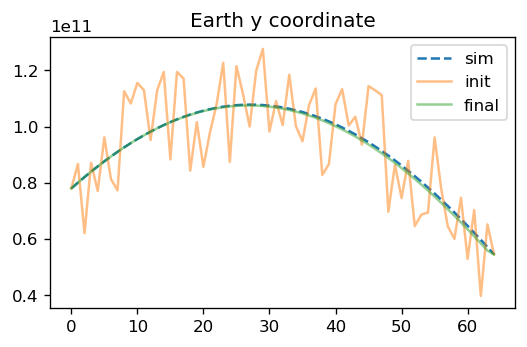

In [20]:
plt.figure(figsize=[5,3], dpi=120)
plt.title('Earth y coordinate')
xs_sim = init_path.x_true
xs_init = xs_min[0].detach().numpy().reshape(-1,N,2)
xs_final = xs_min[-1].detach().numpy().reshape(-1,N,2)
plt.plot(xs_sim[:,2,1], '--', label='sim')
plt.plot(xs_init[:,2,1], alpha=0.5, label='init')
plt.plot(xs_final[:,2,1], alpha=0.5, label='final')
plt.legend()

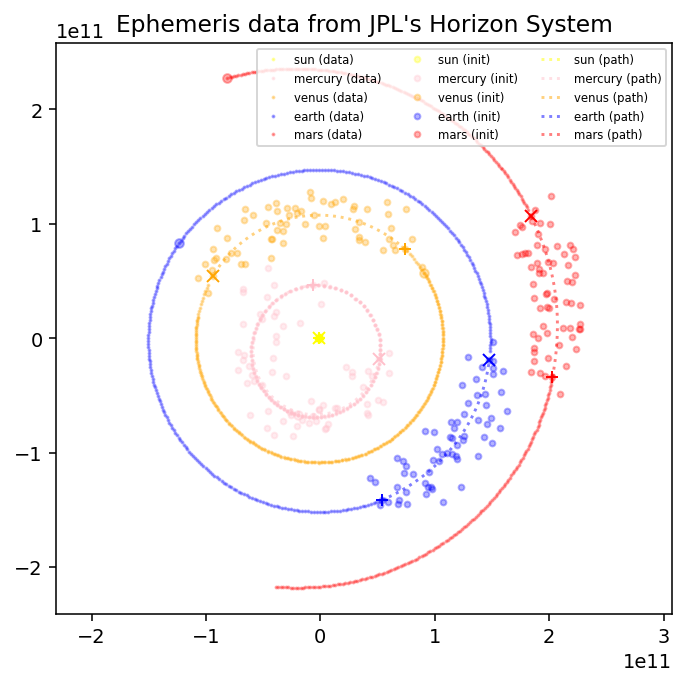

In [21]:
fig = plt.figure(figsize=[5,5], dpi=140)
plot_planets(df, planets, fig=fig)
colors = get_planet_colors()

xs = xs_min[0].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, '.', alpha=0.3, color=colors[planet], label=planets[i] + ' (init)')
    plt.plot(x[0], y[0], '+', color=colors[planet])
    plt.plot(x[-1], y[-1], 'x', color=colors[planet])
    
xs = xs_min[-1].detach().numpy().reshape(-1,N,2)
for i, (planet, coords) in enumerate(zip(planets, xs.transpose(1,2,0))):
    x, y = coords
    plt.plot(x, y, ':', alpha=0.5, color=colors[planet], label=planets[i] + ' (path)')

plt.axis('equal')
plt.legend(fontsize=6,  loc='upper right', ncol=3) ; plt.show()